In [36]:
#importing the necessary packages and configuring some parameters

#basic packages
import pandas as pd
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path

#Packages for data prep
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

#Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

In [37]:
NB_WORDS = 1000 #Parameter indicating the num of words we'll put in the dictionary
NB_START_EPOCHS = 20 #Num of epochs we usually start to train with
BATCH_SIZE = 512 #Size of batches used in the mini-batch gradient descent
MAX_LEN = 20 #Max num of words in a sequence

In [38]:
tweets = pd.read_csv('/content/drive/MyDrive/SureStart/Tweets.csv')
tweets

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,2015-02-22 12:01:01 -0800,NaN,NaN
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2015-02-22 11:59:46 -0800,Texas,NaN
14637,569587242672398336,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,2015-02-22 11:59:15 -0800,"Nigeria,lagos",NaN
14638,569587188687634433,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,2015-02-22 11:59:02 -0800,New Jersey,Eastern Time (US & Canada)


The below snippets of code are "helper functions"

In [62]:
def deep_model(model, xtrain, ytrain, xvalid, yvalid):
  """Function to train a multi-class model. The num of epochs and batch_size are set by the constants at the top of the notebook
  Parameters:
      model : model w/the chosen atchitecture
      xtrain : training features
      ytrain : training target
      xvalid : validation features
      yvalid : validation target 
  Output: 
      model training history"""

  model.compile(optimizer = 'rmsprop'
                    , loss = 'categorical_crossentropy'
                    , metrics = ['accuracy'])
  history = model.fit(xtrain
                          , ytrain
                          , epochs = NB_START_EPOCHS
                          , batch_size = BATCH_SIZE
                          , validation_data = (xvalid, yvalid)
                          , verbose = 0)
  return history 


In [40]:
def eval_metric(model, history, metric_name):
  """Function to evaluate a trained model on a chosen metric. Training and validation metric are plotted in a line chart for each epoch.
  Parameters: 
    history : model training accuracy
    metric_name : loss or accuracy
  Output: 
    line chart with epochs of x-axis and metric on y-axis"""
  metric = history.history[metric_name]
  val_metric = history.history['val_' + metric_name]

  e = range(1, NB_START_EPOCHS + 1)

  plt.plot(e, metric, 'bo', label = 'Train ' + metric_name)
  plt.plot(e, val_metric, 'b', label = 'Validation' + metric_name)
  plt.xlabel('Epoch number')
  plt.ylabel(metric_name)
  plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
  plt.legend()
  plt.show()

In [69]:
def test_model(model, xtrain, ytrain, xtest, ytest, epoch_stop):
  """Function to test the model on new data after training it on the full training data w/the optimal num of epochs.
  Parameters:
        model : training model
        xtrain : training features
        ytrain : training target
        xtest : test features
        ytest : test target
        epochs : optimal num of epochs
  Output: 
    test accuracy and test loss
  """
  model.fit(xtrain
            , ytrain
            , epochs = epoch_stop
            , batch_size = BATCH_SIZE
            , verbose = 0)
  results = model.evaluate(xtest, ytest)
  print()
  print('Test accuracy: {0:.2f}%'.format(results[1] * 100))
  print (results)

In [42]:
def remove_stopwords(input_text):
  """Function to remove English stopwords from a Panda Series.
  Parameters: 
        input_text : text to clean
  Output:
        cleaned Pandas Series"""
  stopwords_list = stopwords.words('english')
  #Some words which might indicate a certain sentiment are kept via a whitelist
  whitelist = ["n't", "not", "no"]
  words = input_text.split()
  clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
  return" ".join(clean_words)

In [43]:
def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)

In [44]:
def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
    '''
    Function to compare a metric between two models 
    
    Parameters:
        model_hist_1 : training history of model 1
        model_hist_2 : training history of model 2
        metrix : metric to compare, loss, acc, val_loss or val_acc
        
    Output:
        plot of metrics of both models
    '''
    metric_model_1 = model_hist_1.history[metric]
    metric_model_2 = model_hist_2.history[metric]
    e = range(1, NB_START_EPOCHS + 1)
    
    metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss'
    }

    metric_label = metrics_dict[metric]
    plt.plot(e, metric_model_1, 'bo', label=model_1.name)
    plt.plot(e, metric_model_2, 'b', label=model_2.name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_label)
    plt.title('Comparing ' + metric_label + ' between models')
    plt.legend()
    plt.show()

In [45]:
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model
    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

In [46]:
import nltk
nltk.download('stopwords')

tweets = pd.read_csv('/content/drive/MyDrive/SureStart/Tweets.csv')
tweets = tweets.reindex(np.random.permutation(tweets.index))  
tweets = tweets[['text', 'airline_sentiment']]
tweets.text = tweets.text.apply(remove_stopwords).apply(remove_mentions)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The evaluation of the model performance needs to be done on a separate test set. As such, we can estimate how well the model generalizes. This is done with the train_test_split method of scikit-learn.

In [47]:
xtrain, xtest, ytrain, ytest = train_test_split(tweets.text, tweets.airline_sentiment, test_size=0.1, random_state=37)


To use the text as input for a model, we first need to convert the words into tokens, which simply means converting the words to integers that refer to an index in a dictionary. Here we will only keep the most frequent words in the training set.
We clean up the text by applying filters and putting the words to lowercase. Words are separated by spaces.

In [48]:
tk = Tokenizer(num_words = NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{"}~\t\n',
               lower=True,
               char_level=False,
               split=' ')
tk.fit_on_texts(xtrain)

After having created the dictionary we can convert the text of a tweet to a vector with NB_WORDS values. With mode=binary, it contains an indicator whether the word appeared in the tweet or not. This is done with the texts_to_matrix method of the Tokenizer.


In [49]:
xtrain_oh = tk.texts_to_matrix(xtrain, mode='binary')
xtest_oh = tk.texts_to_matrix(xtest, mode='binary')

We need to convert the target classes to numbers as well, which in turn are one-hot-encoded with the to_categorical method in Keras

In [50]:
le = LabelEncoder()
ytrain_le = le.fit_transform(ytrain)
ytest_le = le.transform(ytest)
ytrain_oh = to_categorical(ytrain_le)
ytest_oh = to_categorical(ytest_le)

Now that our data is ready, we split off a validation set. This validation set will be used to evaluate the model performance when we tune the parameters of the model.

In [51]:
xtrain_rest, xvalid, ytrain_rest, yvalid = train_test_split(xtrain_oh, ytrain_oh, test_size=0.1, random_state=37)


We start with a model that overfits. It has 2 densely connected layers of 64 elements. The input_shape for the first layer is equal to the number of words we kept in the dictionary and for which we created one-hot-encoded features.



As we need to predict 3 different sentiment classes, the last layer has 3 elements. The softmax activation function makes sure the three probabilities sum up to 1.



The number of parameters to train is computed as (nb inputs x nb elements in hidden layer) + nb bias terms. The number of inputs for the first layer equals the number of words in our corpus. The subsequent layers have the number of outputs of the previous layer as inputs. So the number of parameters per layer are:


First layer : (10000 x 64) + 64 = 640064


Second layer : (64 x 64) + 64 = 4160


Last layer : (64 x 3) + 3 = 195


In [52]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model.names = 'Baseline model'

Because this project is a multi-class, single-label prediction, we use categorical_crossentropy as the loss function and softmax as the final activation function. We fit the model on the train data and validate on the validation set. We run for a predetermined number of epochs and will see when the model starts to overfit.


Minimum validation loss reached in epoch 5


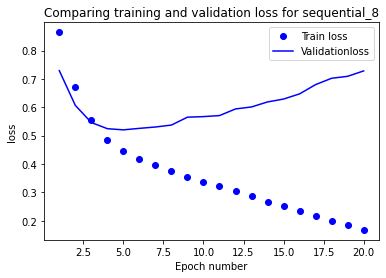

In [53]:
base_history = deep_model(base_model, xtrain_rest, ytrain_rest, xvalid, yvalid)
base_min = optimal_epoch(base_history)
eval_metric(base_model, base_history, 'loss')

Our first model has a large number of trainable parameters. The higher this number, the easier the model can memorize the target class for each training sample. Obviously, this is not ideal for generalizing on new data.


By lowering the capacity of the network, you force it to learn the patterns that matter or that minimize the loss. On the other hand, reducing the network’s capacity too much will lead to underfitting. The model will not be able to learn the relevant patterns in the train data.


We reduce the network’s capacity by removing one hidden layer and lowering the number of elements in the remaining layer to 16.


Minimum validation loss reached in epoch 17


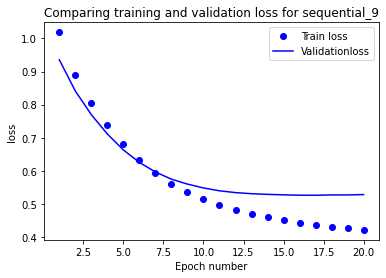

In [54]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(16, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_model.names = 'Reduced model'
reduced_history = deep_model(reduced_model, xtrain_rest, ytrain_rest, xvalid, yvalid)
reduced_min = optimal_epoch(reduced_history)
eval_metric(reduced_model, reduced_history, 'loss')

We can see that it takes more epochs before the reduced model starts overfitting. The validation loss also goes up slower than our first model.


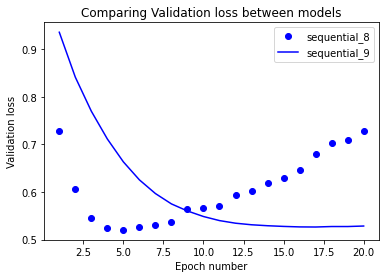

In [55]:
compare_models_by_metric(base_model, reduced_model, base_history, reduced_history, 'val_loss')


When we compare the validation loss of the baseline model, it is clear that the reduced model starts overfitting at a later epoch. The validation loss stays lower much longer than the baseline model.


To address overfitting, we can apply weight regularization to the model. This will add a cost to the loss function of the network for large weights (or parameter values). As a result, you get a simpler model that will be forced to learn only the relevant patterns in the train data.


There are L1 regularization and L2 regularization.


L1 regularization will add a cost with regards to the absolute value of the parameters. It will result in some of the weights to be equal to zero.


L2 regularization will add a cost with regards to the squared value of the parameters. This results in smaller weights.


Let’s try with L2 regularization.

In [56]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model.names = 'L2 Regularization model'
reg_history = deep_model(reg_model, xtrain_rest, ytrain_rest, xvalid, yvalid)
reg_min = optimal_epoch(reg_history)

Minimum validation loss reached in epoch 9


For the regularized model we notice that it starts overfitting in the same epoch as the baseline model. However, the loss increases much slower afterward.


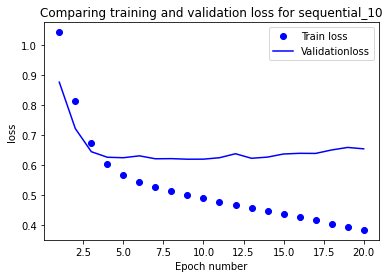

In [57]:
eval_metric(reg_model, reg_history, 'loss')

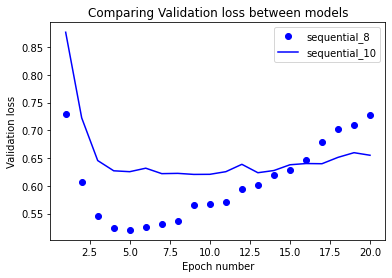

In [58]:
compare_models_by_metric(base_model, reg_model, base_history, reg_history, 'val_loss')

The last option we’ll try is to add Dropout layers. A Dropout layer will randomly set output features of a layer to zero.


Minimum validation loss reached in epoch 9


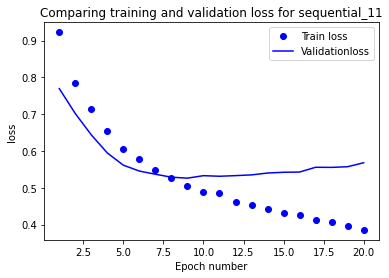

In [59]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_model.names = 'Dropout layers model'
drop_history = deep_model(drop_model, xtrain_rest, ytrain_rest, xvalid, yvalid)
drop_min = optimal_epoch(drop_history)
eval_metric(drop_model, drop_history, 'loss')

The model with dropout layers starts overfitting later than the baseline model. The loss also increases slower than the baseline model.


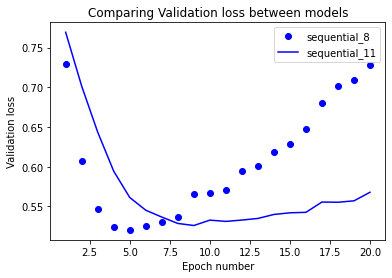

In [60]:
compare_models_by_metric(base_model, drop_model, base_history, drop_history, 'val_loss')

The model with the Dropout layers starts overfitting later. Compared to the baseline model the loss also remains much lower.


At first sight, the reduced model seems to be the best model for generalization. But let’s check that on the test set.


In [70]:
base_results = test_model(base_model, xtrain_oh, ytrain_oh, xtest_oh, ytest_oh, base_min)
reduced_results = test_model(reduced_model, xtrain_oh, ytrain_oh, xtest_oh, ytest_oh, reduced_min)
reg_results = test_model(reg_model, xtrain_oh, ytrain_oh, xtest_oh, ytest_oh, reg_min)
drop_results = test_model(drop_model, xtrain_oh, ytrain_oh, xtest_oh, ytest_oh, drop_min)

46/46 [==============================] - 0s 3ms/step - loss: 0.9021 - accuracy: 0.7637

Test accuracy: 76.37%
[0.9021221995353699, 0.7636612057685852]
46/46 [==============================] - 0s 3ms/step - loss: 0.6029 - accuracy: 0.7630

Test accuracy: 76.30%
[0.6029250621795654, 0.7629781365394592]
46/46 [==============================] - 0s 2ms/step - loss: 0.7675 - accuracy: 0.7541

Test accuracy: 75.41%
[0.7674874067306519, 0.7540983557701111]
46/46 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.7664

Test accuracy: 76.64%
[0.6819365620613098, 0.7663934230804443]
